# Gaussian Mixture Model examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import os,sys,time
sys.path.insert(1, '../../src/')
import madmix
import madmix_aux
import gibbs
from concrete import *
import meanfield
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='fig/'
fig_path='../../../madmix-tex/fig/'

In [2]:
def confusion_matrix(true,pred,K):
    """
    Create a confusion matrix when predicting N labels
    that can take K different values
    
    Inputs:
        true : (N,) array, true labels 
        pred : (N,) array, predicted labels
        K    : int, number of classes
    
    Outputs:
        mat : (K,K) array, confusion matrix
    """
    mat=np.zeros((K,K))
    for k1 in range(K):
        for k2 in range(K):
            mat[k1,k2]=np.logical_and(true==k1, pred==k2).sum()
        # end for
    # end for
    return mat

def permute_labels(pred,dim1,dim2,K):
    """
    Permute the dim1 and dim2 labels of pred
    
    Inputs:
        pred : (N,) array, predicted labels
        dim1 : int, first label to swap
        dim2 : int, second label to swap
        K    : int, number of classes
    
    Outputs:
        perm : (N,) array, permuted labels
    """
    perm=np.copy(pred)
    perm[perm==dim1]=K+1
    perm[perm==dim2]=dim1
    perm[perm==(K+1)]=dim2
    return perm

## Palmer penguin data set

In [96]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
K=3

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65751/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65751/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data


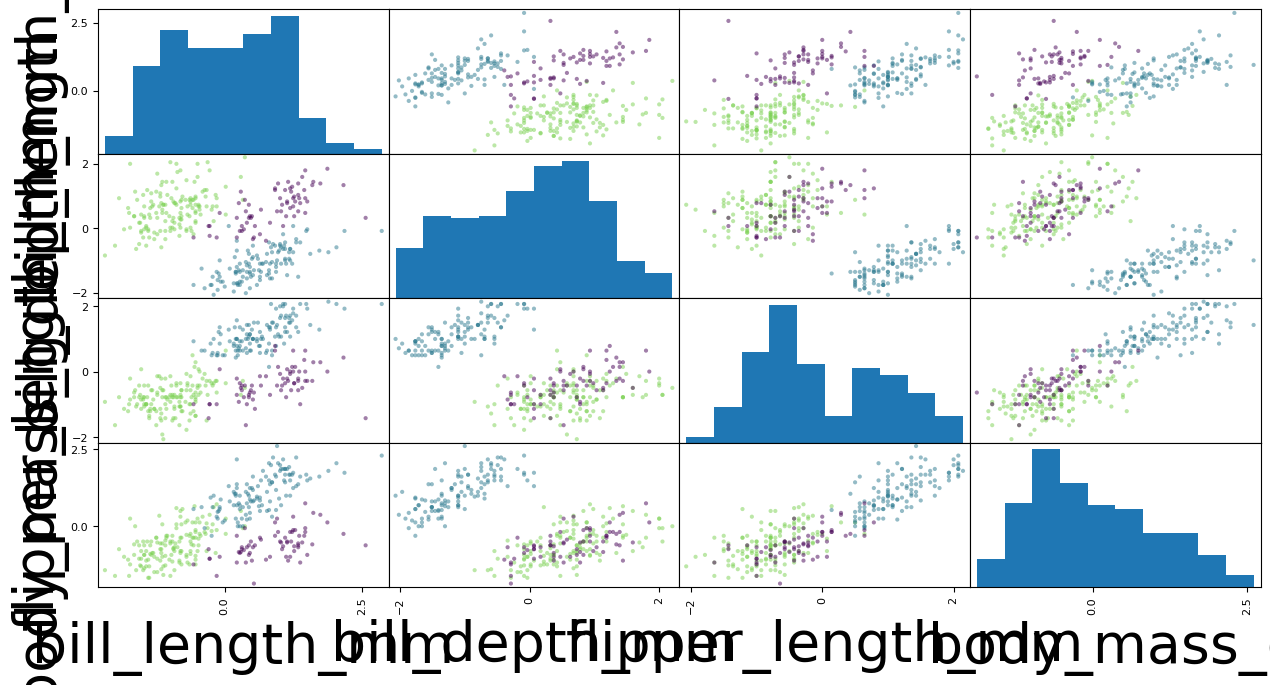

In [97]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [98]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])
pg_true=np.squeeze(np.array(penguins[['species']]))
pg_true[pg_true=='Adelie']=0
pg_true[pg_true=='Gentoo']=1
pg_true[pg_true=='Chinstrap']=2

### Gibbs sampling

In [99]:
####################
####################
#      setup       #
####################
####################

# settings
steps=1000
burnin_pct=0.9
D=pg_dat.shape[1]

# initial arrays
#mu0=np.array([[35.,25.,175.,3500.],  # green
#              [55.,17.,200.,4000.],  # purple 
#              [45.,10.,225.,5000.]]) # blue
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=0.5*np.eye(D)
w0=np.ones(K)/K

In [100]:
####################
####################
#   run sampler    #
####################
####################
seed=1
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=pg_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)

In [41]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/penguin/pred_x')
aux.pkl_save(ws,'sockeye_run/penguin/pred_w')
aux.pkl_save(mus,'sockeye_run/penguin/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/penguin/pred_sigma')

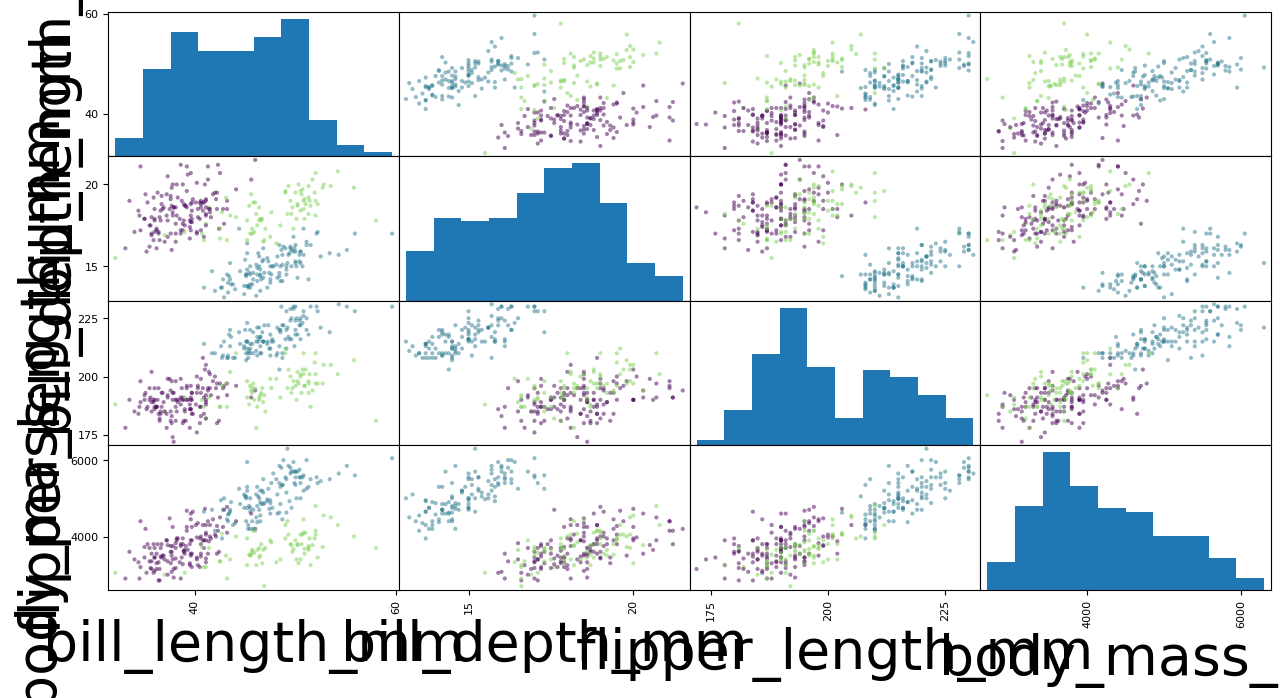

In [101]:
colors[xs[-1,:]==0]='#440154'
colors[xs[-1,:]==1]='#7ad151'
colors[xs[-1,:]==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [102]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T
gibbs_pred_pg=np.argmax(x_prbs,axis=1)

# account for label permutation
gibbs_pred_pg=permute_labels(gibbs_pred_pg,1,2,K)

In [103]:
confusion_matrix(pg_true,gibbs_pred_pg,K)

array([[144.,   0.,   2.],
       [  0., 119.,   0.],
       [  3.,   0.,  65.]])

### MAD Mix

In [ ]:
########################
########################
#    Mad Mix approx    #
########################
########################

# flow settings
sample_size=3
steps=100
L=15
epsilon=0.001
xi=np.pi/16

# initial arrays
N,D=pg_dat.shape
K=3
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
invsigma0=np.zeros((K,D,D))
for k in range(K): 
    sigma0[k,:,:]=0.5*np.eye(D)
    invsigma0[k,:,:]=np.eye(D)/0.5
# end for
w0=np.ones(K)/K
nu0=1.

y = np.array(pg_dat)
randq0=madmix_aux.gen_randq0(N,mu0,sigma0,invsigma0)
lp = madmix_aux.gmm_gen_lp(K,D)
gen_grad_lp=madmix_aux.gmm_gen_grad_lp(K)

### Mean field

In [44]:
####################
####################
#      setup       #
####################
####################
K=3
y=pg_dat
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,4,4))
for k in range(K): sigma0[k,:,:]=1.*np.eye(4)
iterations=10000

In [45]:
####################
####################
#  run optimizer   #
####################
####################
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)

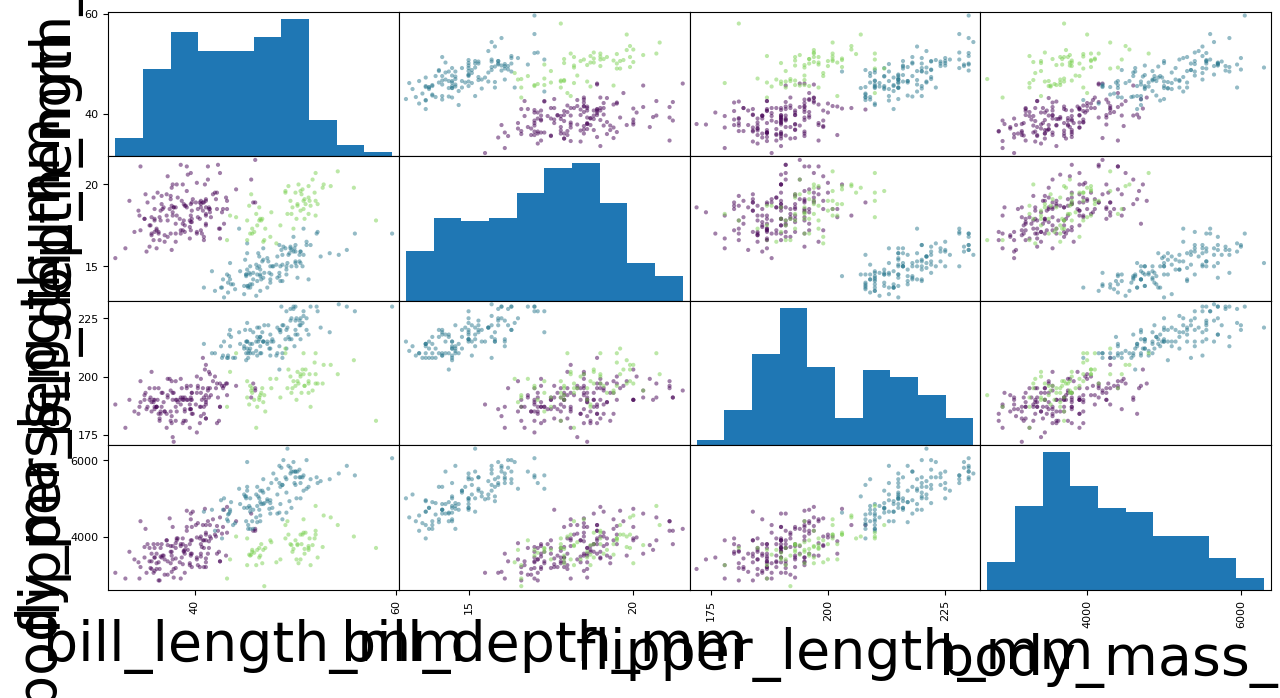

In [46]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[np.argmax(lrs,axis=1)==0]='#440154'
colors[np.argmax(lrs,axis=1)==1]='#7ad151'
colors[np.argmax(lrs,axis=1)==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [104]:
# account for label permutation
mf_pred_pg=np.argmax(lrs,axis=1)
mf_pred_pg=permute_labels(mf_pred_pg,1,2,K)


confusion_matrix(pg_true,mf_pred_pg,K)

array([[145.,   0.,   1.],
       [  0., 119.,   0.],
       [  5.,   0.,  63.]])

### Concrete 

In [47]:
####################
####################
#    load data     #
####################
####################
path='sockeye/penguin/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

losses=np.zeros((len(losses_files),10001))
flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    losses[i]=aux.pkl_load(path+losses_files[i])
    flows[i]=aux.pkl_load(path+flows_files[i])
# end for

Text(0, 0.5, 'Loss')

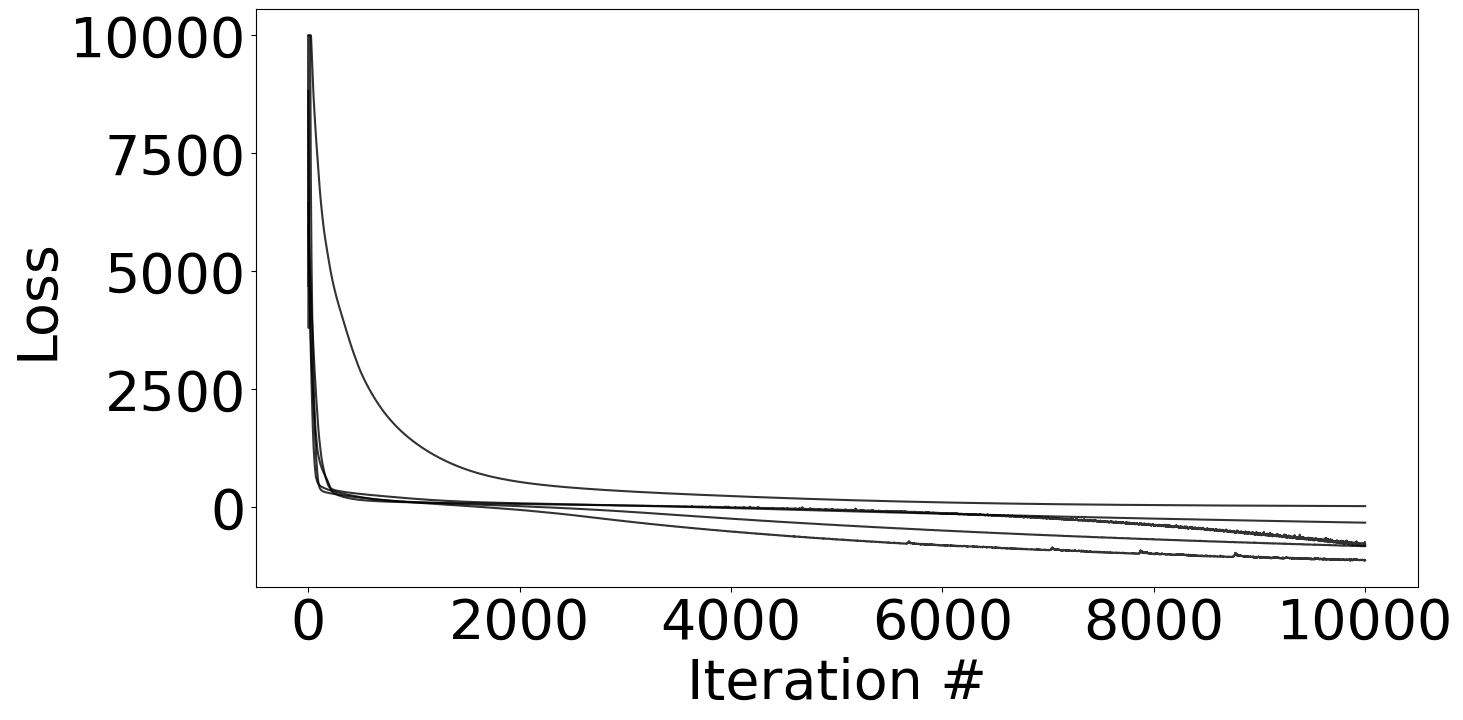

In [48]:
# loss traceplot
threshold=10000
plt_losses=np.copy(losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [49]:
# retrieve best flow
i_star=np.argmin(losses[:,-1])
best_flow=flows[i_star]
print('Optimal flow: '+str(i_star))

Optimal flow: 0


In [ ]:
# generate sample from optimal flow
#torch.manual_seed(1)
#flow_sample=best_flow.sample(10000)

In [86]:
# loss 124 is smallest
# corresponds to: temp: 5, depth: 64, width: 100, lr: 1e-5
# here we train it manually
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
tau0=0.1

temp = 5.
depth = 64
width = 100

lr = 1e-5
max_iters=10001

In [14]:
# sample generation
xs_concrete=torch.from_numpy(xs)
ws_concrete=torch.from_numpy(ws)
mus_concrete=torch.from_numpy(mus)
sigmas_concrete=torch.from_numpy(sigmas)

conc_sample=gmm_concrete_sample(xs_concrete,ws_concrete,mus_concrete,sigmas_concrete,temp)

In [15]:
RUN=False
if RUN:
    tmp_flow_penguin,tmp_loss_penguin=trainGMMRealNVP(
        temp=temp,depth=depth,N=N,K=K,D=D,tau0=tau0,sample=conc_sample,width=width,max_iters=max_iters,lr=lr,seed=2023,verbose=True
    )
# end if

iter 0: loss = 8825.073
iter 1000: loss = 96.729
iter 2000: loss = -65.055
iter 3000: loss = -304.835
iter 4000: loss = -526.478
iter 5000: loss = -692.925
iter 6000: loss = -815.025
iter 7000: loss = -924.330
iter 8000: loss = -1009.998
iter 9000: loss = -1075.286
iter 10000: loss = -1137.199


Text(0, 0.5, 'Loss')

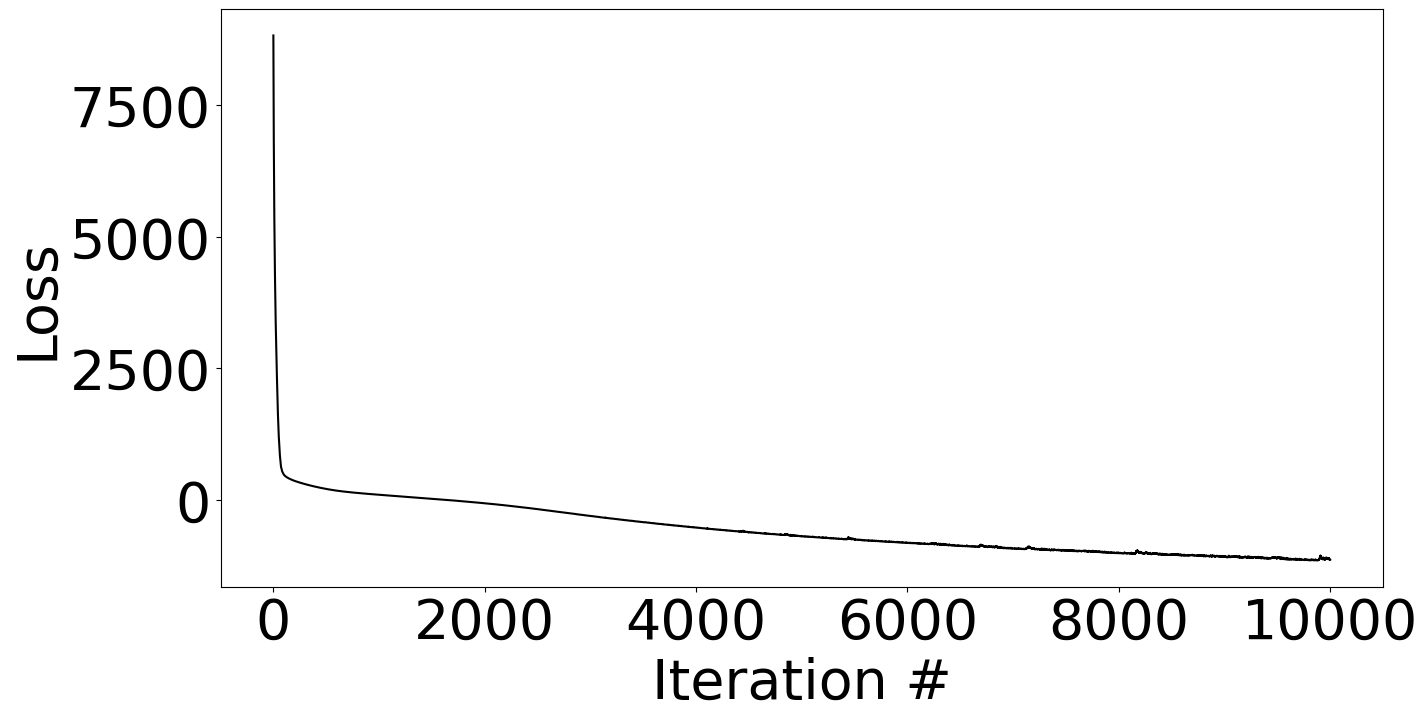

In [34]:
plt.plot(np.arange(10001),tmp_loss_penguin,c='black')
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [84]:
# generate sample from optimal flow
torch.manual_seed(1)
flow_sample=tmp_flow_penguin.sample(10000)

In [94]:
xd_pg,ws_pg,mus_pg,Sigmas_pg=concrete_gmm_unpack(flow_sample,N,K,D)
ws_pg,mus_pg,Sigmas_pg=ws_pg.detach().numpy(),mus_pg.detach().numpy(),Sigmas_pg.detach().numpy()

In [128]:
pg_cols_one=np.argmax(np.exp(xd_pg),axis=1)[:,0]

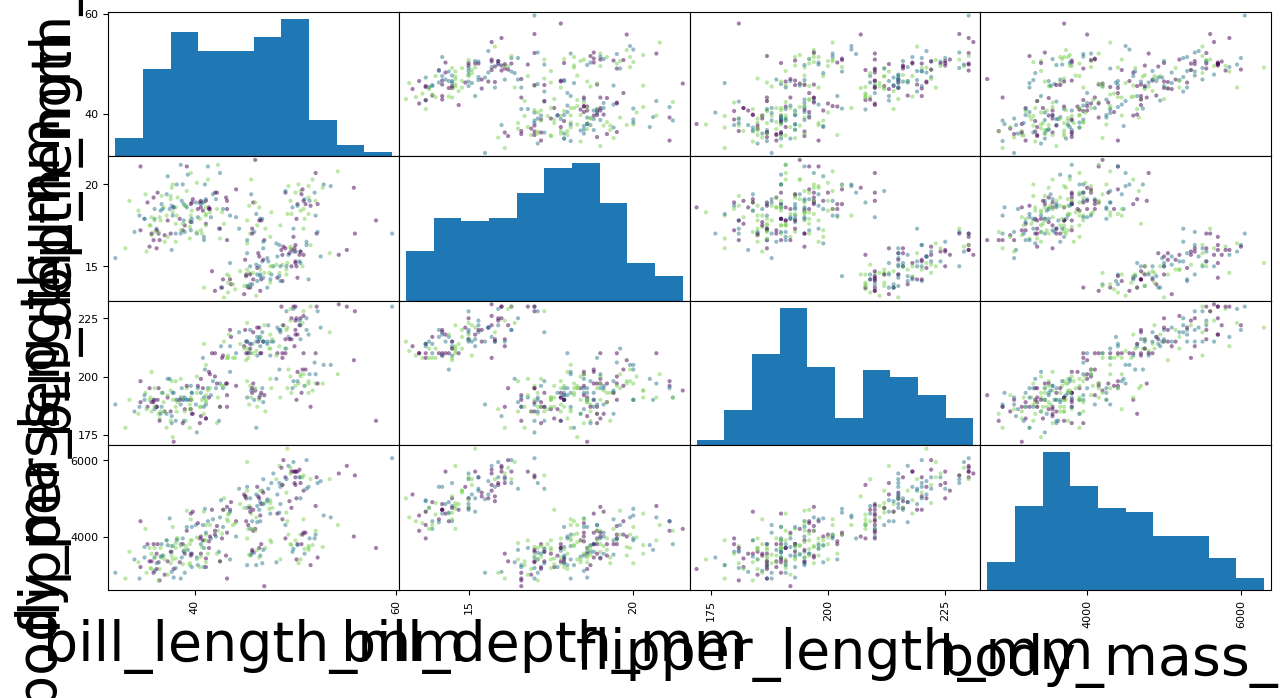

In [129]:
colors[pg_cols_one==0]='#440154'
colors[pg_cols_one==1]='#7ad151'
colors[pg_cols_one==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

## Waveform data set

In [105]:
from sklearn.decomposition import PCA
waveform_dat=pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/waveform.train')
pca = PCA(n_components=4)
pca.fit(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])
waveform_pca=np.array(waveform_dat[waveform_dat.columns.difference(['row.names','y'])])@pca.components_.T

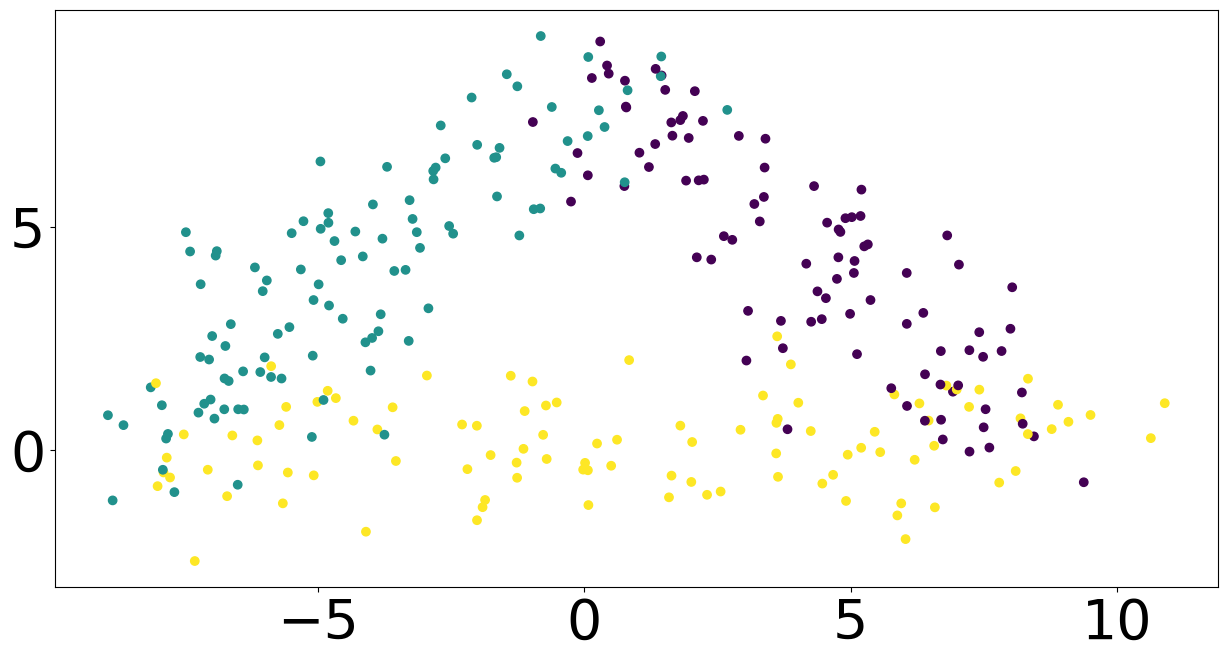

In [106]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.squeeze(np.array(waveform_dat[['y']])))

In [124]:
wf_true=np.squeeze(np.array(waveform_dat[['y']]))-1
wf_dat=waveform_pca[:,:2]
K=3

### Gibbs sampling

In [108]:
####################
####################
#      setup       #
####################
####################

# settings
steps=1000
burnin_pct=0.9
D=wf_dat.shape[1]

# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=5.*np.eye(D)
w0=np.ones(K)/K

In [109]:
####################
####################
#   run sampler    #
####################
####################
seed=1
xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=wf_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)

In [ ]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(xs,'sockeye_run/waveform/pred_x')
aux.pkl_save(ws,'sockeye_run/waveform/pred_w')
aux.pkl_save(mus,'sockeye_run/waveform/pred_mu')
aux.pkl_save(sigmas,'sockeye_run/waveform/pred_sigma')

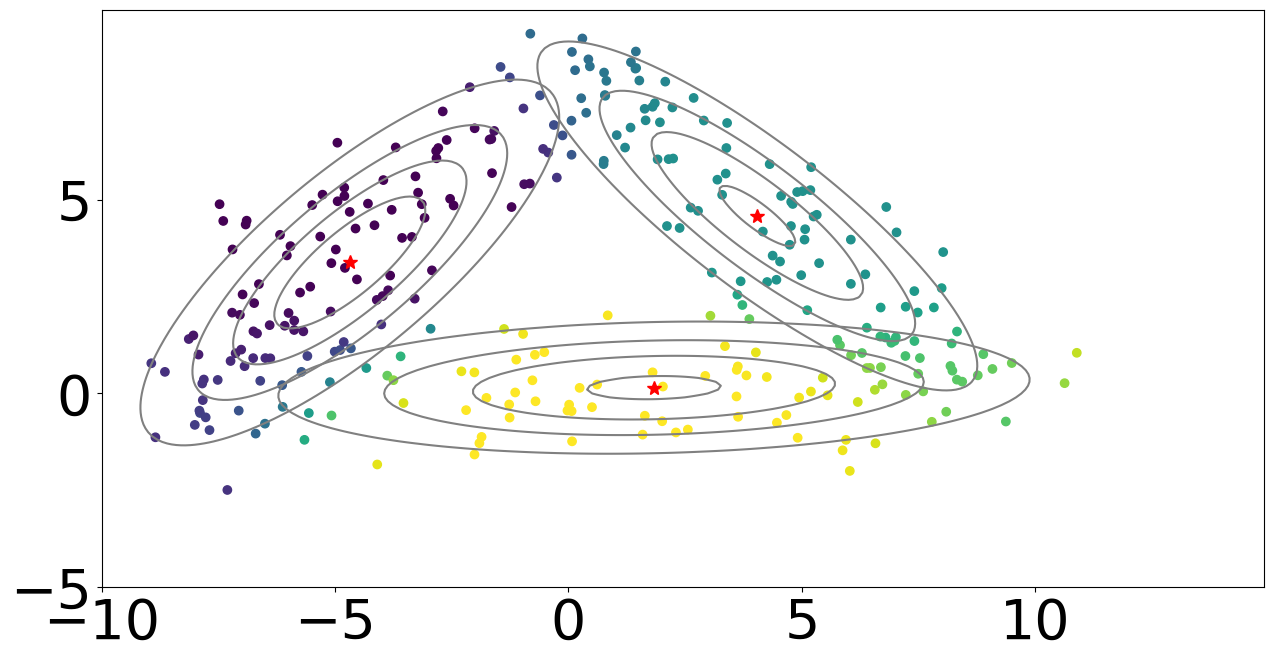

In [110]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(xs,axis=0))
plt.plot(np.mean(mus,axis=0)[:,0],np.mean(mus,axis=0)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(np.mean(mus,axis=0)[k,:], np.mean(sigmas,axis=0)[k,:,:])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [125]:
pred_x=xs.T
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,None,None],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[None,:]).T

In [128]:
# account for label permutation
gibbs_pred_wf=np.argmax(x_prbs,axis=1)
gibbs_pred_wf=permute_labels(gibbs_pred_wf,0,1,K)

confusion_matrix(wf_true,gibbs_pred_wf,K)

array([[82.,  3.,  9.],
       [10., 95.,  1.],
       [11., 19., 70.]])

### Mean field

In [129]:
####################
####################
#      setup       #
####################
####################
K=3
y=wf_dat
# initial arrays
mu0=np.array([[-3.,4.],  # blue
              [ 5.,4.],  # purple 
              [ 0.,0.]]) # yellow
sigma0=np.zeros((K,2,2))
for k in range(K): sigma0[k,:,:]=5.*np.eye(2)
iterations=10000

In [130]:
####################
####################
#  run optimizer   #
####################
####################
alphas,lrs,ms,betas,invWs,nus=meanfield.meanfieldGMM(y,mu0,sigma0,iterations)

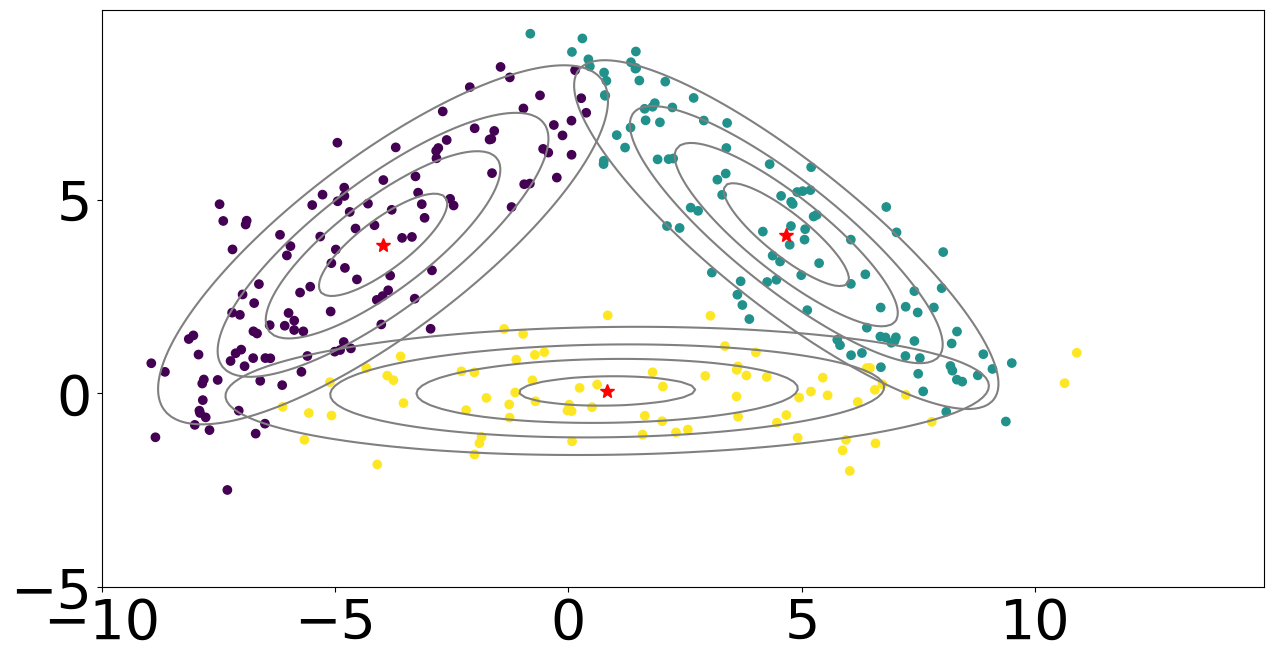

In [131]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.argmax(lrs,axis=1))
plt.plot(ms[:,0],ms[:,1],'*r',ms=10)

xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(ms[k,:], invWs[k,:,:]/nus[k])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=4,colors='grey')

In [133]:
# account for label permutation
mf_pred_wf=np.argmax(lrs,axis=1)
mf_pred_wf=permute_labels(mf_pred_wf,0,1,K)


confusion_matrix(wf_true,mf_pred_wf,K)

array([[84.,  5.,  5.],
       [ 7., 97.,  2.],
       [16., 18., 66.]])

### Concrete

In [ ]:
####################
####################
#    load data     #
####################
####################
path='sockeye/waveform/cache/'
files=os.listdir(path)
losses_files=[file[:-4] for file in files if 'losses' in file] # only get name without extension
flows_files=[file[:-4] for file in files if 'flows' in file]

losses=np.zeros((len(losses_files),10001))
flows=[None for i in range(len(losses_files))]
for i in range(len(losses_files)): 
    losses[i]=aux.pkl_load(path+losses_files[i])
    flows[i]=aux.pkl_load(path+flows_files[i])
# end for

In [ ]:
# loss traceplot
threshold=10000
plt_losses=np.copy(losses)
plt_losses[plt_losses>threshold]=threshold
for i in range(len(losses_files)): plt.plot(np.arange(10001),plt_losses[i,:],c='black',alpha=0.8)
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [ ]:
# retrieve best flow
i_star=np.argmin(losses[:,-1])
best_flow=flows[i_star]
print('Optimal flow: '+str(i_star))

In [ ]:
# generate sample from optimal flow
#torch.manual_seed(1)
#flow_sample=best_flow.sample(10000)

In [99]:
# loss 122 is smallest
# corresponds to: temp: 5, depth: 64, width: 50, lr: 1e-03
# here we train it manually
N,K,D=xs.shape[1],mus.shape[1],mus.shape[2]
tau0=0.1

temp = 5.
depth = 64
width = 50

lr = 1e-3
max_iters=10001

In [23]:
# sample generation
xs_concrete=torch.from_numpy(xs)
ws_concrete=torch.from_numpy(ws)
mus_concrete=torch.from_numpy(mus)
sigmas_concrete=torch.from_numpy(sigmas)

conc_sample=gmm_concrete_sample(xs_concrete,ws_concrete,mus_concrete,sigmas_concrete,temp)

In [24]:
RUN=False
if RUN:
    tmp_flow_waveform,tmp_loss_waveform=trainGMMRealNVP(
        temp=temp,depth=depth,N=N,K=K,D=D,tau0=tau0,sample=conc_sample,width=width,max_iters=max_iters,lr=lr,seed=2023,verbose=True
    )
# end if

iter 0: loss = 7110.931
iter 1000: loss = -246.430
iter 2000: loss = -1137.064
iter 3000: loss = -1863.825
iter 4000: loss = -2132.695
iter 5000: loss = -2471.192
iter 6000: loss = -2644.854
iter 7000: loss = -2804.740
iter 8000: loss = -2938.585
iter 9000: loss = -3014.458
iter 10000: loss = -3042.336


Text(0, 0.5, 'Loss')

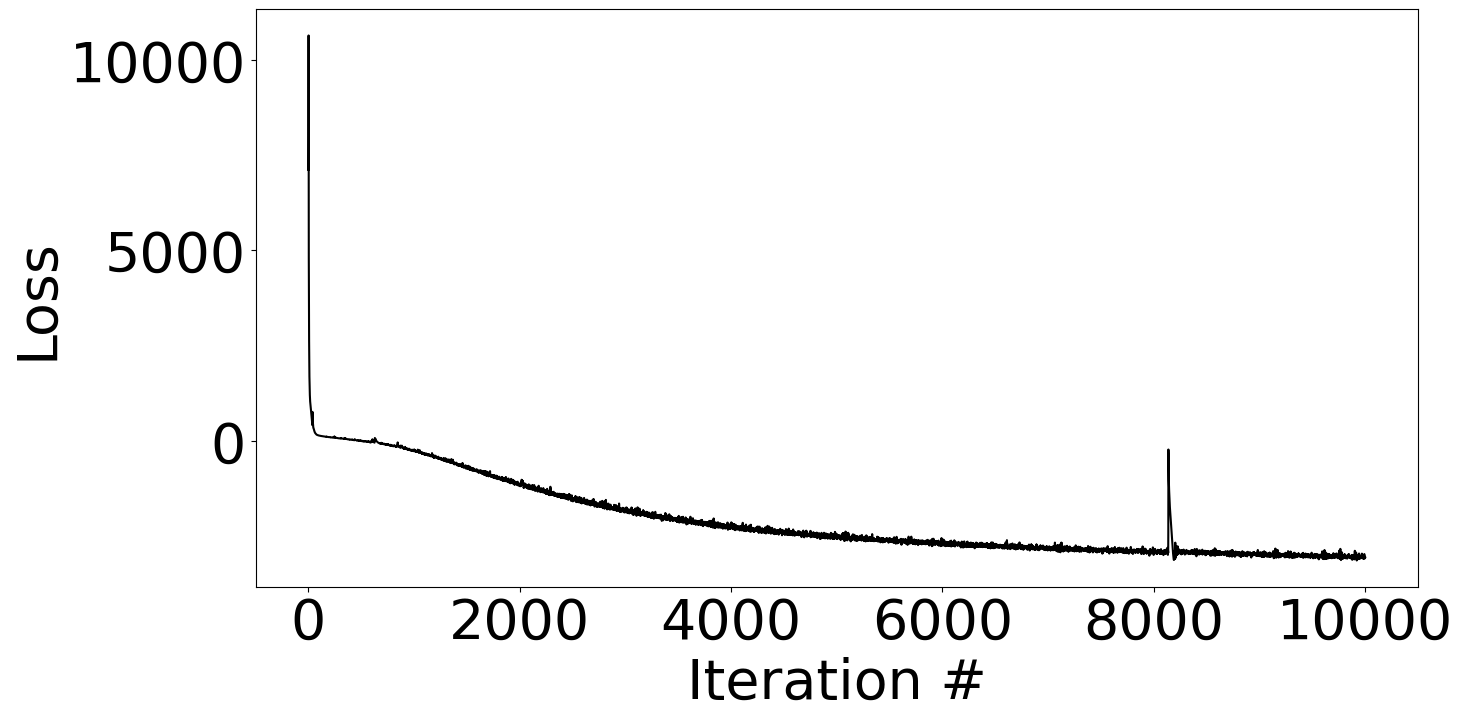

In [73]:
plt.plot(np.arange(10001),tmp_loss_waveform,c='black')
plt.xlabel('Iteration #')
plt.ylabel('Loss')

In [74]:
# generate sample from optimal flow
torch.manual_seed(1)
flow_sample_waveform=tmp_flow_waveform.sample(10000)

In [100]:
xd_wf,ws_wf,mus_wf,Sigmas_wf=concrete_gmm_unpack(flow_sample_waveform,N,K,D)
ws_wf,mus_wf,Sigmas_wf=ws_wf.detach().numpy(),mus_wf.detach().numpy(),Sigmas_wf.detach().numpy()

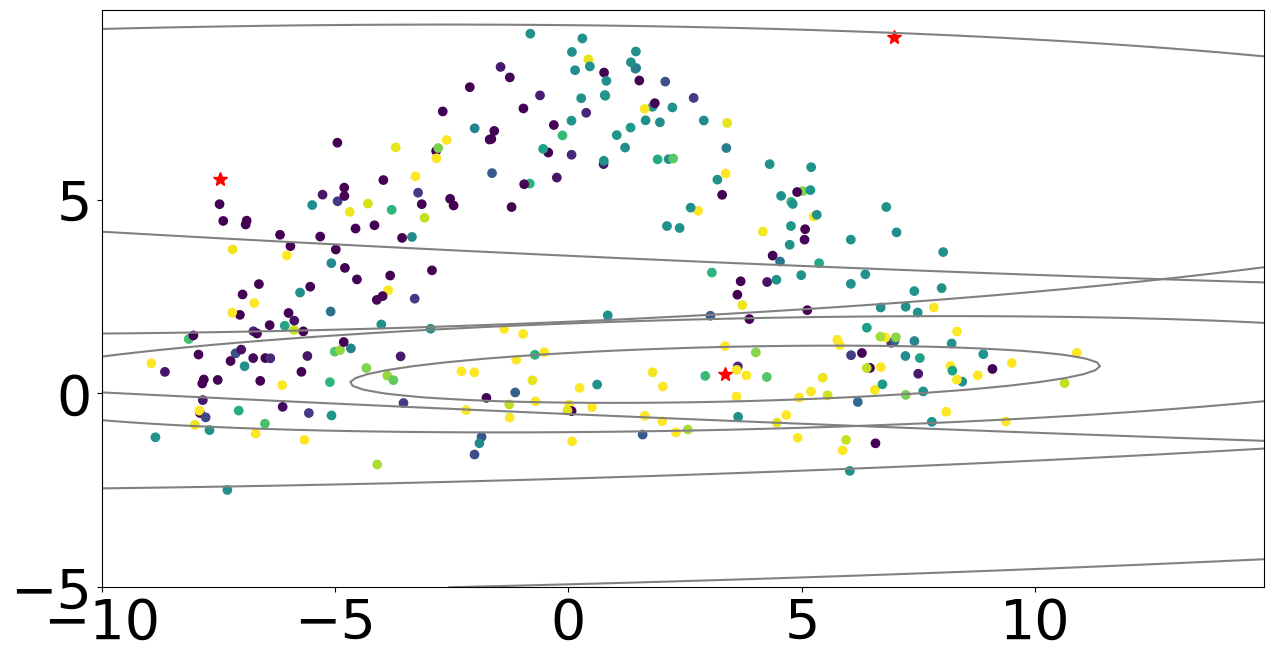

In [122]:
plt.scatter(waveform_pca[:,0],waveform_pca[:,1],c=np.mean(np.argmax(np.exp(xd_wf),axis=1),axis=1))
plt.plot(np.mean(mus_wf,axis=2)[:,0],np.mean(mus_wf,axis=2)[:,1],'*r',ms=10)


xx, yy = np.mgrid[-10:15:.1, -5:10:.1]
data = np.dstack((xx, yy))
for k in range(K):
    rv = stats.multivariate_normal(np.mean(mus_wf,axis=2)[k,:], np.mean(Sigmas_wf,axis=3)[k,:,:])
    zz = rv.pdf(data)
    plt.contour(xx, yy, zz,levels=2,colors='grey')